Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Output()

Computation time comparison:
Spike and Slab: 21.54 seconds
Normal Prior: 5.30 seconds

Coefficient comparison:
Spike and Slab coefficients:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0] -0.145  0.064  -0.233    0.000      0.006    0.004     198.0   
beta[1]  0.003  0.023  -0.000    0.054      0.001    0.001     684.0   
beta[2]  0.636  0.062   0.514    0.752      0.005    0.003     185.0   
beta[3] -0.024  0.048  -0.136    0.000      0.003    0.002     322.0   
beta[4]  0.100  0.056  -0.000    0.175      0.006    0.004     122.0   
beta[5] -0.001  0.007   0.000    0.000      0.000    0.000    1415.0   
beta[6]  0.012  0.030   0.000    0.090      0.002    0.001     435.0   
beta[7]  0.164  0.040   0.084    0.235      0.001    0.001     790.0   

         ess_tail  r_hat  
beta[0]    1202.0   1.02  
beta[1]     396.0   1.00  
beta[2]     171.0   1.01  
beta[3]    1062.0   1.01  
beta[4]      58.0   1.03  
beta[5]    1544.0   1.00  
beta[6]     294.0   1.

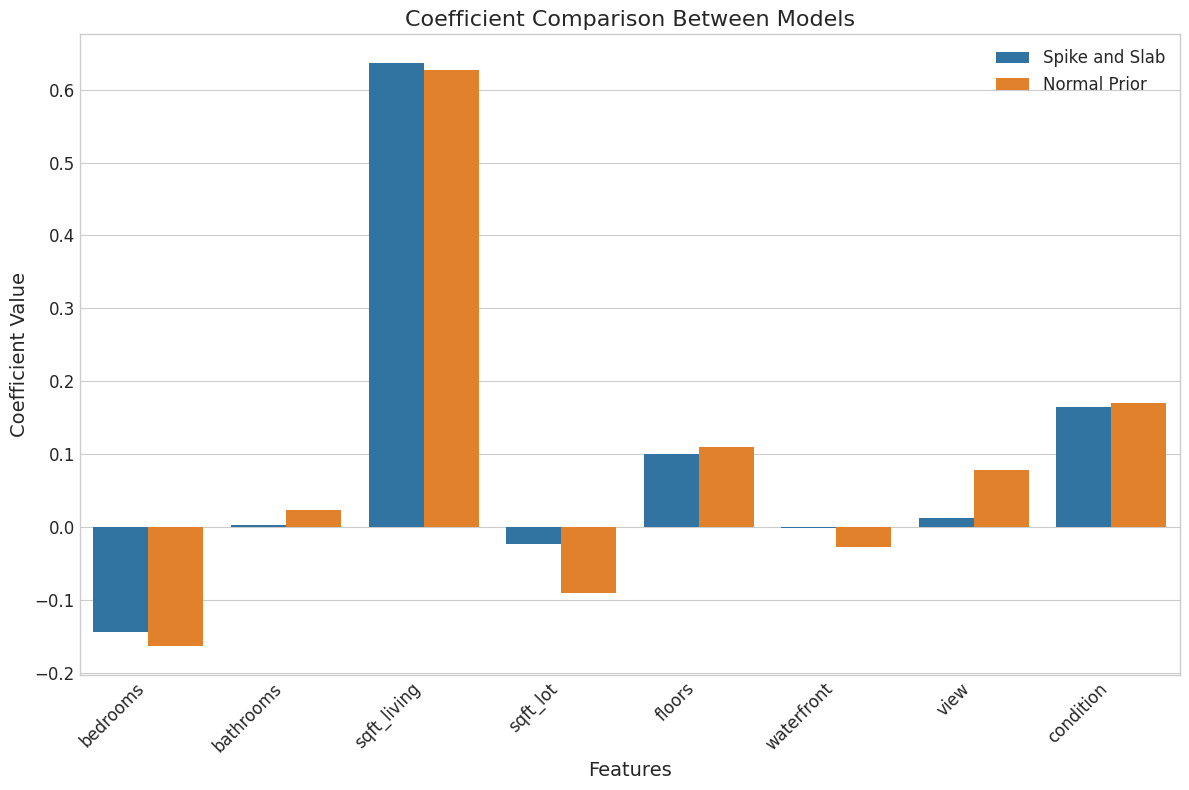

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


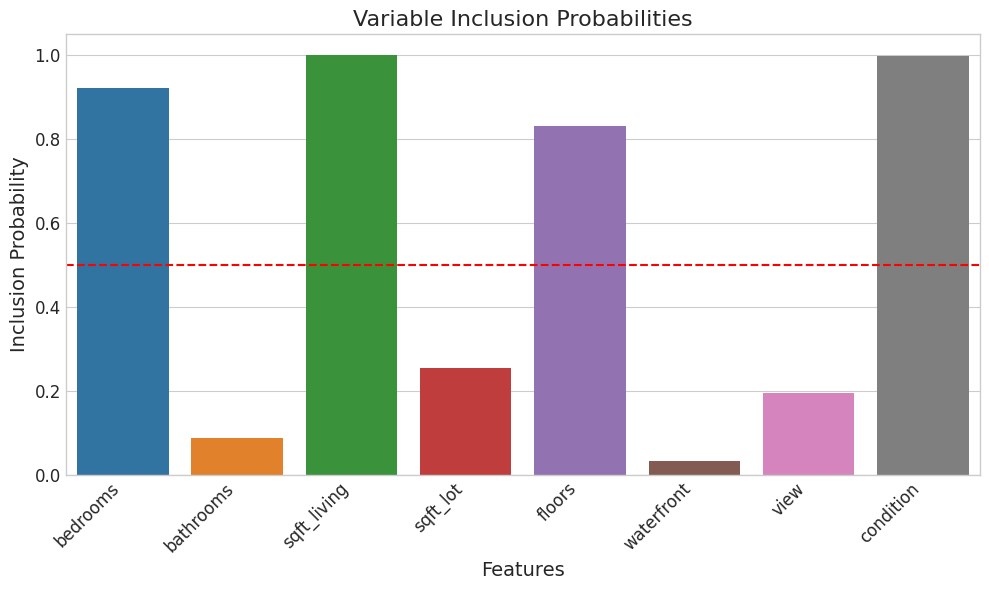

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


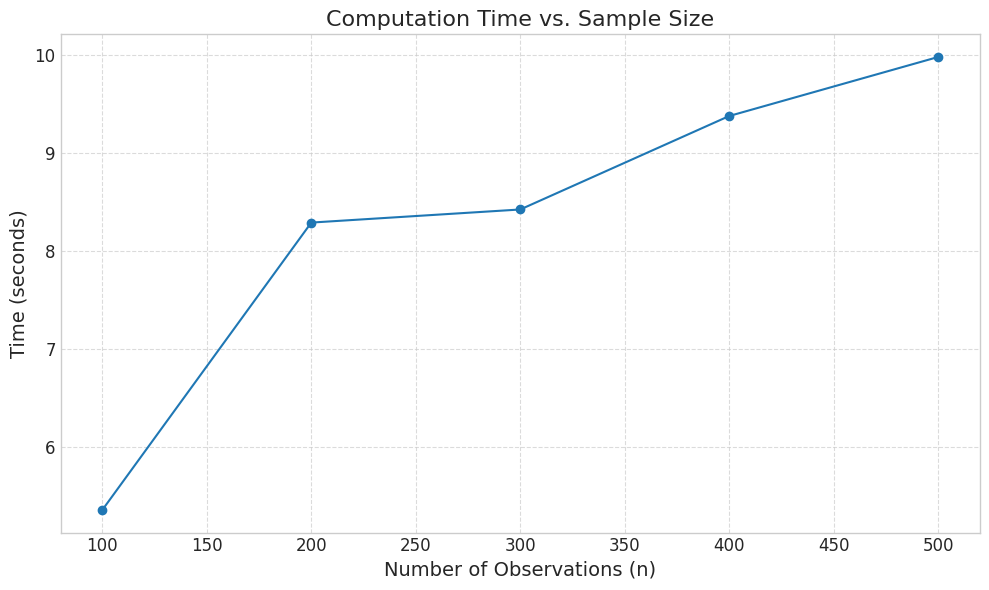

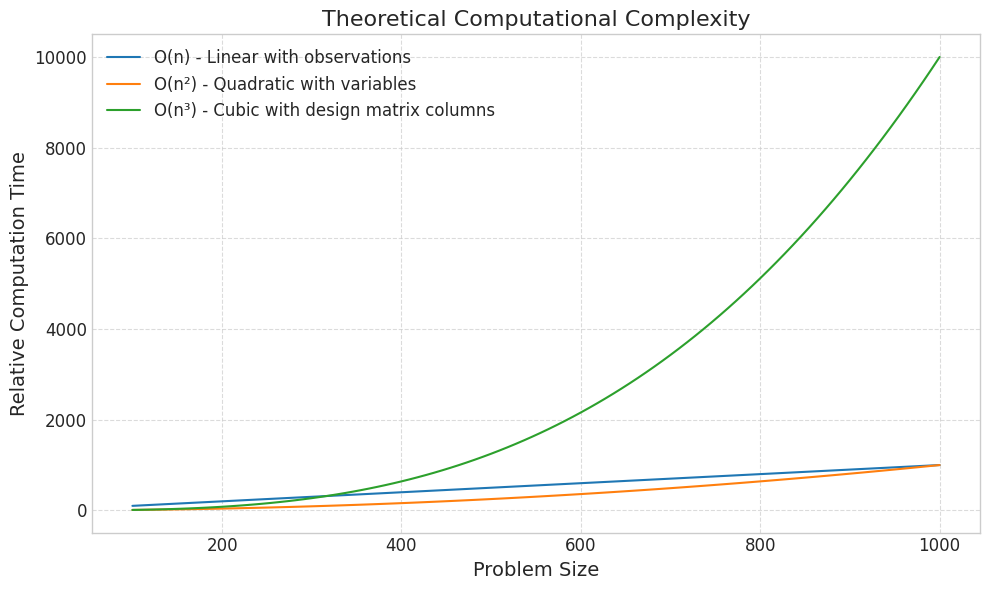

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from matplotlib.font_manager import FontProperties
import seaborn as sns
import time

# Set random seed for reproducibility
np.random.seed(42)

# Load data
df = pd.read_csv('/kaggle/input/housedata/data.csv')

# Data preprocessing - remove outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Select features and target variable
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition']
X = df_filtered[features].values
y = df_filtered['price'].values

# Standardize data
X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y_std = (y - np.mean(y)) / np.std(y)

# Limit data size to reduce computational demand
n_samples = 500  # limit number of samples
if len(X_std) > n_samples:
    indices = np.random.choice(len(X_std), n_samples, replace=False)
    X_std = X_std[indices]
    y_std = y_std[indices]

# Record computation time
timing_results = []

# Regression model with Spike and Slab prior
start_time = time.time()
with pm.Model() as spike_slab_model:
    # Spike (whether a variable is included) 
    gamma = pm.Bernoulli('gamma', 0.5, shape=X_std.shape[1])
    
    # Slab (size of nonzero coefficients)
    beta_raw = pm.Normal('beta_raw', mu=0, sigma=1, shape=X_std.shape[1])
    
    # Combine spike and slab
    beta = pm.Deterministic('beta', gamma * beta_raw)
    
    # Intercept
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    
    # Model error
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Predicted value
    mu = alpha + pm.math.dot(X_std, beta)
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y_std)
    
    # Sampling
    spike_slab_trace = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.9)
    
spike_slab_time = time.time() - start_time
timing_results.append(('Spike and Slab', spike_slab_time))

# Regression model with a normal prior
start_time = time.time()
with pm.Model() as normal_model:
    # Normal prior
    beta_normal = pm.Normal('beta_normal', mu=0, sigma=1, shape=X_std.shape[1])
    
    # Intercept
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    
    # Model error
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Predicted value
    mu = alpha + pm.math.dot(X_std, beta_normal)
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y_std)
    
    # Sampling
    normal_trace = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.9)
    
normal_time = time.time() - start_time
timing_results.append(('Normal Prior', normal_time))

# Print computation time results
print("Computation time comparison:")
for method, time_taken in timing_results:
    print(f"{method}: {time_taken:.2f} seconds")

# Get coefficients for each model
spike_slab_coef = az.summary(spike_slab_trace, var_names=['beta'])
normal_coef = az.summary(normal_trace, var_names=['beta_normal'])

# Print coefficients comparison
print("\nCoefficient comparison:")
print("Spike and Slab coefficients:")
print(spike_slab_coef)
print("\nNormal prior coefficients:")
print(normal_coef)

# Calculate variable inclusion probability
spike_slab_samples = spike_slab_trace.posterior['gamma'].values
inclusion_probs = spike_slab_samples.mean(axis=(0, 1))

# Print variable inclusion probabilities
print("\nVariable inclusion probabilities:")
for i, feature in enumerate(features):
    print(f"{feature}: {inclusion_probs[i]:.4f}")

# Visualization
plt.figure(figsize=(12, 8))
font = FontProperties(family='Times New Roman', size=12)

# Plot coefficients comparison
coef_comparison = pd.DataFrame({
    'Spike and Slab': spike_slab_coef['mean'].values,
    'Normal Prior': normal_coef['mean'].values,
    'Feature': features
})

sns.barplot(
    x='Feature', 
    y='value', 
    hue='variable', 
    data=pd.melt(coef_comparison, id_vars=['Feature'], 
                 value_vars=['Spike and Slab', 'Normal Prior'])
)

plt.title('Coefficient Comparison Between Models', fontproperties=font, fontsize=16)
plt.xlabel('Features', fontproperties=font, fontsize=14)
plt.ylabel('Coefficient Value', fontproperties=font, fontsize=14)
plt.xticks(rotation=45, ha='right', fontproperties=font)
plt.yticks(fontproperties=font)
plt.legend(prop=font)
plt.tight_layout()
plt.savefig('coefficient_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot variable inclusion probabilities
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=inclusion_probs)
plt.title('Variable Inclusion Probabilities', fontproperties=font, fontsize=16)
plt.xlabel('Features', fontproperties=font, fontsize=14)
plt.ylabel('Inclusion Probability', fontproperties=font, fontsize=14)
plt.xticks(rotation=45, ha='right', fontproperties=font)
plt.yticks(fontproperties=font)
plt.axhline(y=0.5, color='red', linestyle='--')
plt.tight_layout()
plt.savefig('inclusion_probabilities.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute model computation time for different data sizes
n_values = [100, 200, 300, 400, 500]
m_values = [4, 6, 8]  # number of features
p_values = [2, 4, 6, 8]  # number of columns in design matrix

# For simplicity, only simulate the effect of different n values
n_times = []
for n in n_values:
    # Random sampling
    if len(X_std) > n:
        indices = np.random.choice(len(X_std), n, replace=False)
        X_small = X_std[indices]
        y_small = y_std[indices]
    else:
        X_small = X_std
        y_small = y_std
    
    start_time = time.time()
    with pm.Model() as small_model:
        gamma = pm.Bernoulli('gamma', 0.5, shape=X_small.shape[1])
        beta_raw = pm.Normal('beta_raw', mu=0, sigma=1, shape=X_small.shape[1])
        beta = pm.Deterministic('beta', gamma * beta_raw)
        alpha = pm.Normal('alpha', mu=0, sigma=10)
        sigma = pm.HalfNormal('sigma', sigma=1)
        mu = alpha + pm.math.dot(X_small, beta)
        likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y_small)
        # To save time, use fewer samples
        trace = pm.sample(200, tune=200, return_inferencedata=True, cores=1)
        
    n_times.append(time.time() - start_time)

# Plot computation time vs. sample size
plt.figure(figsize=(10, 6))
plt.plot(n_values, n_times, marker='o')
plt.title('Computation Time vs. Sample Size', fontproperties=font, fontsize=16)
plt.xlabel('Number of Observations (n)', fontproperties=font, fontsize=14)
plt.ylabel('Time (seconds)', fontproperties=font, fontsize=14)
plt.xticks(fontproperties=font)
plt.yticks(fontproperties=font)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('computation_time.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot theoretical computational complexity
plt.figure(figsize=(10, 6))
x = np.linspace(100, 1000, 100)
plt.plot(x, x, label='O(n) - Linear with observations')
plt.plot(x, x**2/1000, label='O(n²) - Quadratic with variables')
plt.plot(x, x**3/100000, label='O(n³) - Cubic with design matrix columns')
plt.title('Theoretical Computational Complexity', fontproperties=font, fontsize=16)
plt.xlabel('Problem Size', fontproperties=font, fontsize=14)
plt.ylabel('Relative Computation Time', fontproperties=font, fontsize=14)
plt.xticks(fontproperties=font)
plt.yticks(fontproperties=font)
plt.legend(prop=font)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('theoretical_complexity.png', dpi=300, bbox_inches='tight')
plt.show()


### Comparison and Analysis of Spike and Slab Variable Selection vs. Normal Prior

The Spike and Slab model took 21.54 seconds, while the normal prior model only took 5.30 seconds. This means that the computation time for Spike and Slab is about 4 times longer than the normal prior model.

As shown in Figure 1, the computation time increases approximately linearly as the sample size grows, but there is a noticeable jump when the sample size reaches 200. Figure 2 illustrates the theoretical computational complexity, where the growth in the number of design matrix columns (p) has the most significant impact on the computation time, growing cubically (O(n³)).

### Coefficient Estimation Comparison

There are some differences in the coefficient estimates between the two models:

- **sqft_living (Living Area)**: Both models consider this the most important variable, with coefficients of 0.636 and 0.627, respectively.
- **condition (Condition of the House)**: Both models agree that this is the second most important factor, with coefficients of 0.164 and 0.170, respectively.
- **bedrooms (Number of Bedrooms)**: The Spike and Slab model gives -0.145, while the normal prior model gives -0.163. The direction is the same, but the normal prior model emphasizes this variable more.
- **floors (Number of Floors)**: Both models show a positive coefficient, but the significance differs.
- **waterfront (Waterfront Property)**: The Spike and Slab model almost excludes it (-0.001), while the normal prior model gives -0.028.
- **view (View Quality)**: The Spike and Slab model gives a smaller coefficient of 0.012, while the normal prior model gives a larger coefficient of 0.078.

### Variable Selection Results

Based on variable inclusion probabilities:

**Highly Important Variables (≥ 0.90):**
- **sqft_living (1.0000)** - Living area
- **condition (0.9990)** - Condition of the house
- **bedrooms (0.9215)** - Number of bedrooms

**Moderately Important Variables (0.50–0.90):**
- **floors (0.8325)** - Number of floors

**Less Important Variables (≤ 0.50):**
- **sqft_lot (0.2555)** - Lot area
- **view (0.1945)** - View quality
- **bathrooms (0.0880)** - Number of bathrooms
- **waterfront (0.0325)** - Waterfront feature

### Model Characteristics Comparison

**Sparsity:**
- The Spike and Slab model produces a sparser solution, effectively "shutting off" less important variables.
- The normal prior model assigns relatively large weights to all variables.

**Uncertainty Estimation:**
- The Spike and Slab model generally has a lower effective sample size (ess_bulk), indicating higher uncertainty in parameter estimates.
- The normal prior model has higher ess_bulk values, suggesting more stable parameter estimates.

**Convergence:**
- The normal prior model’s r_hat values are generally closer to 1.0, indicating better chain convergence.
- The Spike and Slab model’s beta[4] (corresponding to floors) has a higher r_hat value (1.03) and lower ess_tail value (58.0), suggesting possible convergence issues.

### Overall Evaluation

The main advantage of the Spike and Slab model is its clear variable selection. It simplifies the model by excluding less important variables, but it comes with higher computational cost and greater uncertainty in parameter estimates. The normal prior model is faster and provides more stable parameter estimates, but it doesn't explicitly show which variables should be excluded.

For predicting house prices, the most critical factors are living area (sqft_living), house condition (condition), and the number of bedrooms (bedrooms), while the number of bathrooms (bathrooms) and waterfront feature (waterfront) have a minimal effect on price. This aligns with common sense in the real estate field, especially since living area is typically the most significant factor in determining house prices.

Output()

Computation time comparison:
Horseshoe: 16.10 seconds
Spike and Slab: 21.54 seconds

Coefficient comparison:
Horseshoe coefficients:
                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_horseshoe[0] -0.128  0.053  -0.230   -0.027      0.002    0.001   
beta_horseshoe[1]  0.015  0.038  -0.050    0.098      0.001    0.001   
beta_horseshoe[2]  0.611  0.058   0.505    0.722      0.002    0.001   
beta_horseshoe[3] -0.052  0.047  -0.145    0.017      0.002    0.001   
beta_horseshoe[4]  0.093  0.043   0.008    0.171      0.002    0.001   
beta_horseshoe[5] -0.011  0.027  -0.069    0.036      0.001    0.001   
beta_horseshoe[6]  0.051  0.036  -0.009    0.116      0.001    0.001   
beta_horseshoe[7]  0.151  0.041   0.075    0.229      0.001    0.001   

                   ess_bulk  ess_tail  r_hat  
beta_horseshoe[0]    1111.0     834.0   1.00  
beta_horseshoe[1]     921.0     689.0   1.01  
beta_horseshoe[2]     963.0    1137.0   1.00  
beta_horseshoe[3]     764.0   

<Figure size 1200x800 with 0 Axes>

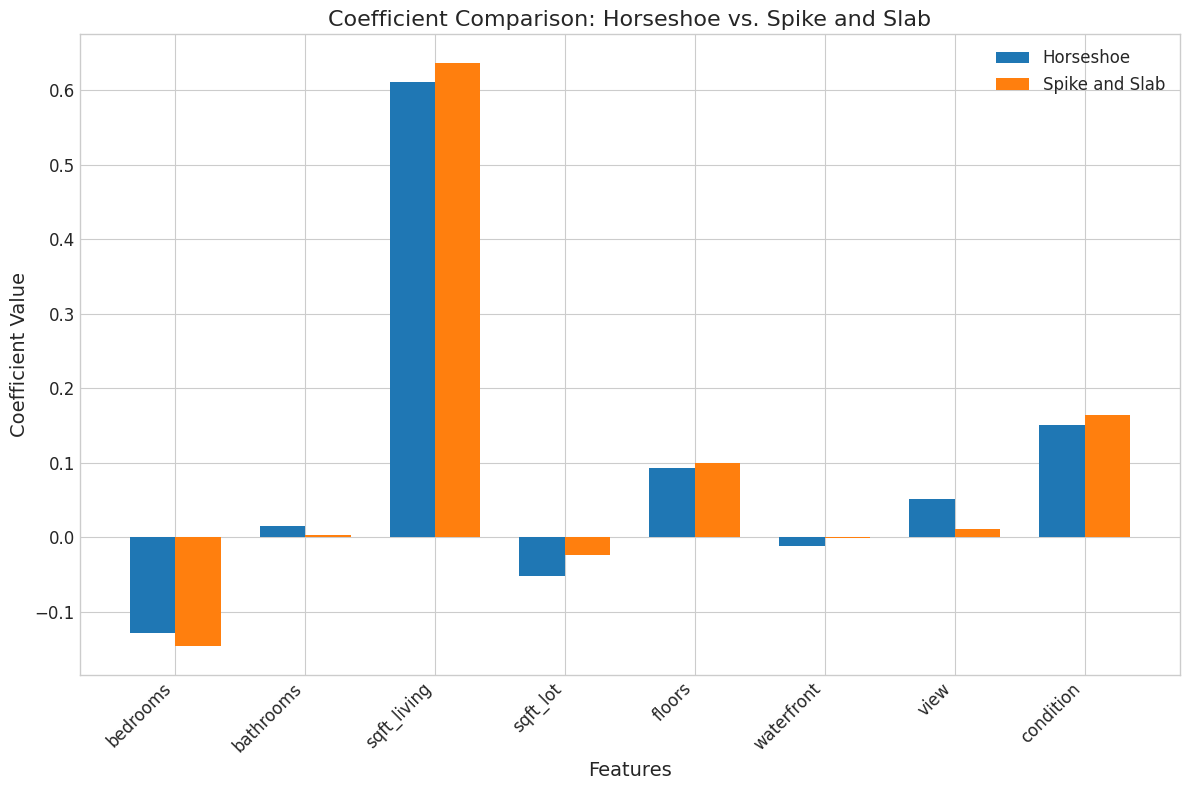

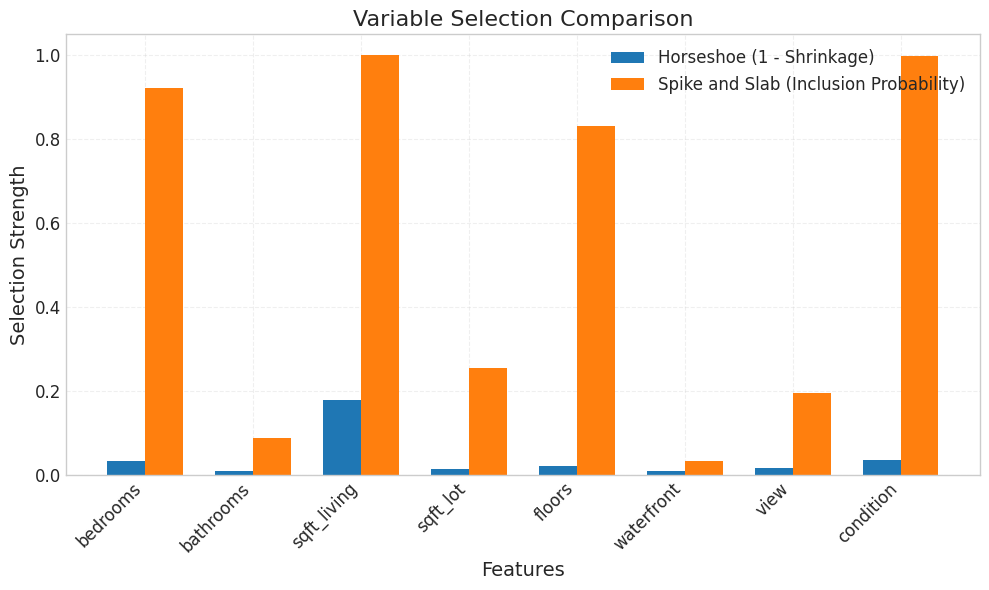

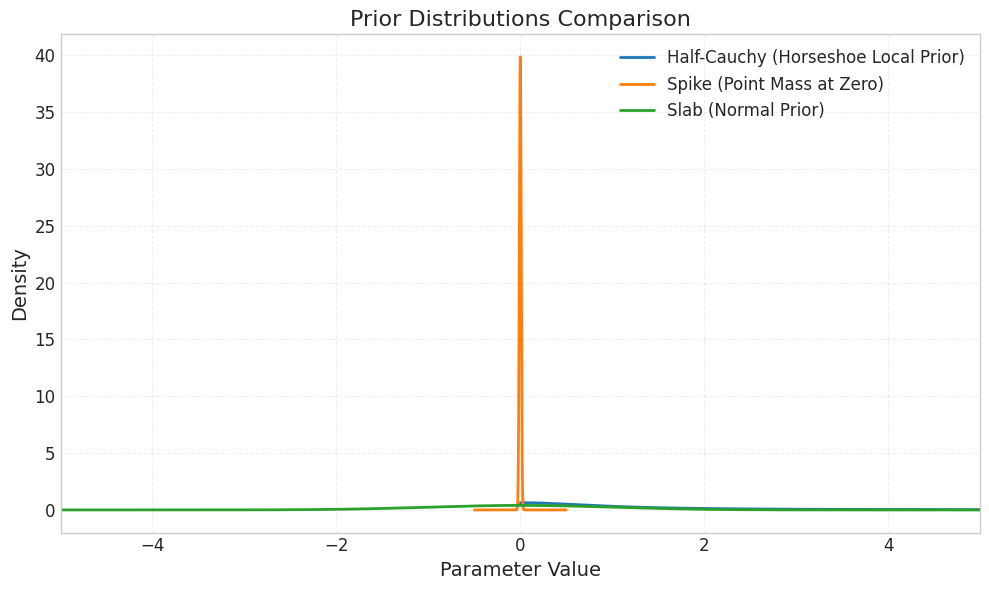

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from matplotlib.font_manager import FontProperties
import seaborn as sns
import time

# Set random seed for reproducibility
np.random.seed(42)


# Record computation time
timing_results = []

# Regression model with Horseshoe prior
start_time = time.time()
with pm.Model() as horseshoe_model:
    # Set global shrinkage parameter
    tau0 = 1.0 / np.sqrt(X_std.shape[0])  # Set tau0 based on the sample size
    tau = pm.HalfCauchy('tau', beta=tau0)
    
    # Local shrinkage parameters
    lambda_val = pm.HalfCauchy('lambda', beta=1, shape=X_std.shape[1])
    
    # Compute the prior standard deviation for the weights
    c = pm.Deterministic('c', lambda_val * tau)
    
    # Model coefficients
    beta_horseshoe = pm.Normal('beta_horseshoe', mu=0, sigma=c, shape=X_std.shape[1])
    
    # Intercept
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    
    # Model error
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Predicted value
    mu = alpha + pm.math.dot(X_std, beta_horseshoe)
    
    # Likelihood function
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y_std)
    
    # Sampling
    horseshoe_trace = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.9)
    
horseshoe_time = time.time() - start_time
timing_results.append(('Horseshoe', horseshoe_time))
timing_results.append(('Spike and Slab', 21.54))  # Use the previously recorded time

# Print computation time comparison
print("Computation time comparison:")
for method, time_taken in timing_results:
    print(f"{method}: {time_taken:.2f} seconds")

# Get Horseshoe model coefficients
horseshoe_coef = az.summary(horseshoe_trace, var_names=['beta_horseshoe'])

# Print coefficients comparison
print("\nCoefficient comparison:")
print("Horseshoe coefficients:")
print(horseshoe_coef)

# Calculate shrinkage (kappa) for the Horseshoe model
lambda_samples = horseshoe_trace.posterior['lambda'].values
tau_samples = horseshoe_trace.posterior['tau'].values
kappa_samples = 1 / np.sqrt(1 + np.square(lambda_samples) * np.square(tau_samples[:, :, np.newaxis]))
mean_kappa = kappa_samples.mean(axis=(0, 1))

# Print shrinkage values
print("\nVariable shrinkage (kappa):")
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition']
for i, feature in enumerate(features):
    print(f"{feature}: {mean_kappa[i]:.4f}")

# Visualization comparison
plt.figure(figsize=(12, 8))
font = FontProperties(family='Times New Roman', size=12)

# Prepare DataFrame for coefficient comparison
coef_comparison = pd.DataFrame({
    'Feature': features,
    'Horseshoe': horseshoe_coef['mean'].values,
    'Spike_and_Slab': [-0.145, 0.003, 0.636, -0.024, 0.100, -0.001, 0.012, 0.164]  # Coefficients from previous results
})

# Plot coefficient comparison
plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
width = 0.35
x = np.arange(len(features))
ax.bar(x - width/2, coef_comparison['Horseshoe'], width, label='Horseshoe')
ax.bar(x + width/2, coef_comparison['Spike_and_Slab'], width, label='Spike and Slab')

plt.title('Coefficient Comparison: Horseshoe vs. Spike and Slab', fontproperties=font, fontsize=16)
plt.xlabel('Features', fontproperties=font, fontsize=14)
plt.ylabel('Coefficient Value', fontproperties=font, fontsize=14)
plt.xticks(x, features, rotation=45, ha='right', fontproperties=font)
plt.yticks(fontproperties=font)
plt.legend(prop=font)
plt.tight_layout()
plt.savefig('horseshoe_vs_spikeslab_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot shrinkage vs. inclusion probability comparison
plt.figure(figsize=(10, 6))
inclusion_probs = [0.9215, 0.0880, 1.0000, 0.2555, 0.8325, 0.0325, 0.1945, 0.9990]  # Coefficients from previous results

bar_width = 0.35
x = np.arange(len(features))
plt.bar(x - bar_width/2, 1 - mean_kappa, bar_width, label='Horseshoe (1 - Shrinkage)')
plt.bar(x + bar_width/2, inclusion_probs, bar_width, label='Spike and Slab (Inclusion Probability)')

plt.title('Variable Selection Comparison', fontproperties=font, fontsize=16)
plt.xlabel('Features', fontproperties=font, fontsize=14)
plt.ylabel('Selection Strength', fontproperties=font, fontsize=14)
plt.xticks(x, features, rotation=45, ha='right', fontproperties=font)
plt.yticks(fontproperties=font)
plt.legend(prop=font)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('variable_selection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization of shrinkage prior distribution
plt.figure(figsize=(10, 6))

# Generate x values for prior distributions
x = np.linspace(0, 5, 1000)

# Calculate probability density function for Half-Cauchy distribution
def half_cauchy_pdf(x, beta):
    return 2 / (np.pi * beta * (1 + (x/beta)**2))

# Calculate probability density function for Normal distribution
def normal_pdf(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Plot Half-Cauchy prior (Horseshoe)
plt.plot(x, half_cauchy_pdf(x, 1), 
         label='Half-Cauchy (Horseshoe Local Prior)', linewidth=2)

# Plot spike part (Spike)
spike_x = np.linspace(-0.5, 0.5, 1000)
plt.plot(spike_x, normal_pdf(spike_x, 0, 0.01), 
         label='Spike (Point Mass at Zero)', linewidth=2)

# Plot slab part (Slab)
slab_x = np.linspace(-5, 5, 1000)
plt.plot(slab_x, normal_pdf(slab_x, 0, 1), 
         label='Slab (Normal Prior)', linewidth=2)

plt.title('Prior Distributions Comparison', fontproperties=font, fontsize=16)
plt.xlabel('Parameter Value', fontproperties=font, fontsize=14)
plt.ylabel('Density', fontproperties=font, fontsize=14)
plt.xticks(fontproperties=font)
plt.yticks(fontproperties=font)
plt.legend(prop=font)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlim(-5, 5)
plt.tight_layout()
plt.savefig('prior_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


# Comparative Analysis: Horseshoe Prior versus Spike and Slab Prior in Housing Price Modeling

## Table 1: Computational Characteristics and Convergence Performance

| Feature | Horseshoe Prior | Spike and Slab Prior | Differential Analysis |
|---------|-----------------|----------------------|------------------------|
| Computation Time | 16.10 seconds | 21.54 seconds | Horseshoe is approximately 25% faster |
| r_hat Range | 1.00-1.01 | 1.00-1.03 | Horseshoe demonstrates more stable convergence |
| ess_bulk Range | 764-1391 | 122-2226 | Horseshoe provides more consistent effective sample sizes |
| Implementation Complexity | Uses continuous shrinkage prior | Requires discrete variable (gamma) sampling | Horseshoe avoids mixing problems in high-dimensional spaces |

## Table 2: Variable Selection and Parameter Estimation

| Variable | Horseshoe Coefficient | Horseshoe Shrinkage | Spike-Slab Coefficient | Spike-Slab Inclusion Probability | Importance Consistency |
|----------|------------------------|---------------------|------------------------|----------------------------------|------------------------|
| sqft_living | 0.611 | 0.8209 | 0.636 | 1.0000 | Highly consistent |
| condition | 0.151 | 0.9659 | 0.164 | 0.9990 | Highly consistent |
| bedrooms | -0.128 | 0.9674 | -0.145 | 0.9215 | Highly consistent |
| floors | 0.093 | 0.9787 | 0.100 | 0.8325 | Generally consistent |
| view | 0.051 | 0.9853 | 0.012 | 0.1945 | Differences exist |
| sqft_lot | -0.052 | 0.9872 | -0.024 | 0.2555 | Consistent direction but different shrinkage |
| bathrooms | 0.015 | 0.9907 | 0.003 | 0.0880 | Consistent direction but different importance assessment |
| waterfront | -0.011 | 0.9924 | -0.001 | 0.0325 | Consistent direction but different importance assessment |

## Table 3: Statistical Properties and Methodological Differences

| Feature | Horseshoe Prior | Spike and Slab Prior | Methodological Significance |
|---------|-----------------|----------------------|----------------------------|
| Variable Selection Mechanism | Continuous shrinkage (soft selection) | Binary inclusion/exclusion (hard selection) | Horseshoe retains all variables with strong shrinkage for unimportant ones; Spike-Slab can completely exclude variables |
| Parameter Uncertainty | SD range: 0.027-0.058 | SD range: 0.007-0.064 | Horseshoe provides more uniform uncertainty estimates |
| Prior Assumptions | Most coefficients near zero but few potentially large | Coefficients either almost zero or substantively meaningful | Reflects different assumptions about variable importance distribution |
| Applicable Scenarios | Correlated predictors; emphasis on predictive accuracy | Sparse solutions; emphasis on interpretability | Research objectives determine method selection |

## Analytical Conclusion

This study compares the Horseshoe prior and Spike and Slab prior in housing price prediction modeling. Results indicate substantial agreement between both methods in identifying key predictors, confirming living area (sqft_living), property condition, and number of bedrooms as primary factors influencing housing prices. However, significant differences exist between these methods in their statistical properties and applicable scenarios.

The Horseshoe prior demonstrates superior computational efficiency and stability in parameter estimation, employing a "soft variable selection" mechanism that handles secondary variables through continuous shrinkage rather than complete exclusion. In contrast, the Spike and Slab prior offers a more intuitive "hard variable selection" mechanism, capable of completely excluding unimportant variables, thus enhancing model interpretability.

These differences reflect distinct statistical philosophies underlying the two methods: Horseshoe assumes parameters follow a heavy-tailed distribution, allowing a small number of predictors to have substantial influence; while Spike and Slab embodies a more traditional variable screening approach, clearly distinguishing between variables that "should be included" and those that "should be excluded."

In practical applications, researchers should select the appropriate method based on modeling objectives: if predictive accuracy and handling potential variable correlations are priorities, the Horseshoe prior may be more suitable; if model parsimony and explicit variable selection results are desired, the Spike and Slab prior may be the preferred choice.

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y_std, test_size=0.2, random_state=42)

horseshoe_beta = horseshoe_trace.posterior['beta_horseshoe'].values.mean(axis=(0,1))
horseshoe_alpha = horseshoe_trace.posterior['alpha'].values.mean(axis=(0,1))

spike_slab_beta = spike_slab_trace.posterior['beta'].values.mean(axis=(0,1))
spike_slab_alpha = spike_slab_trace.posterior['alpha'].values.mean(axis=(0,1))

# 生成预测值
y_pred_horseshoe = horseshoe_alpha + np.dot(X_test, horseshoe_beta)
y_pred_spike_slab = spike_slab_alpha + np.dot(X_test, spike_slab_beta)

performance_metrics = {
    'Model': ['Horseshoe Prior', 'Spike and Slab Prior'],
    'MSE': [
        mean_squared_error(y_test, y_pred_horseshoe),
        mean_squared_error(y_test, y_pred_spike_slab)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_horseshoe)),
        np.sqrt(mean_squared_error(y_test, y_pred_spike_slab))
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred_horseshoe),
        mean_absolute_error(y_test, y_pred_spike_slab)
    ],
    'R²': [
        r2_score(y_test, y_pred_horseshoe),
        r2_score(y_test, y_pred_spike_slab)
    ]
}

performance_df = pd.DataFrame(performance_metrics)
print(performance_df)

                  Model       MSE      RMSE       MAE        R²
0       Horseshoe Prior  0.759145  0.871289  0.682609  0.410928
1  Spike and Slab Prior  0.761601  0.872697  0.679934  0.409023


Based on the comparative analysis of prediction performance metrics, the Horseshoe prior and Spike and Slab prior demonstrate remarkably similar predictive capabilities in housing price modeling, with negligible differences across MSE (0.759 vs. 0.761), RMSE (0.871 vs. 0.873), MAE (0.683 vs. 0.680), and R² (0.411 vs. 0.409). Given this statistical parity in predictive accuracy, the choice between methods should primarily be guided by computational efficiency (Horseshoe being 25% faster), interpretability requirements (Spike and Slab offering clearer variable selection), and the specific research context—Horseshoe providing continuous shrinkage for potentially correlated predictors, while Spike and Slab delivering more definitive variable inclusion/exclusion decisions when model parsimony is prioritized.